In [1]:
import tensorflow as tf
import keras
import os
import cv2
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from skimage.metrics import structural_similarity as ssim
from keras.models import load_model
from scipy.stats import gaussian_kde
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Resizing, UpSampling2D, Dense
from tensorflow.keras.models import Sequential

In [ ]:
def loss_ssim(y_true, y_pred):
    # Calculer le data_range
    data_range = tf.reduce_max(y_true) - tf.reduce_min(y_true)
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=data_range))

In [ ]:
def residual_block(x, filters, kernel_size=3, stride=1, activate=True):
    shortcut = x
    # Convolutions
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        # Ajuste les dimensions
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def residual_block_recon(x, filters, kernel_size=3, stride=1, activate=True):
    shortcut = x
    # Première convolution
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Deuxième convolution
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Ajuste les dimensions
    shortcut = tf.keras.layers.Conv2DTranspose(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def create_resnet_autoencoder(shape=(150, 150, 1), input_latent=64):
    input_img = tf.keras.Input(shape=shape)
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', use_bias=False)(input_img)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same')(x)

    # Encodeur
    x = residual_block(x, 64, 3, 2)
    x = residual_block(x, 128, 3, 2)
    x = residual_block(x, 250, 3, 2)
    x = residual_block(x, 512, 3, 2)
    x = residual_block(x, 250, 3, 1)
    x = tf.keras.layers.Flatten()(x)
    latent_space_layer = tf.keras.layers.Dense(input_latent, activation='relu', use_bias=False)(x)
    latent_space_layer_norm = tf.keras.layers.BatchNormalization(name='latent_space_layer_norm')(latent_space_layer)

    # Décodeur
    reshape_layer = tf.keras.layers.Reshape(target_shape=(1,1,input_latent))(latent_space_layer_norm)
    x_recon = residual_block_recon(reshape_layer, 256, 3, 2)
    x_recon = residual_block_recon(x_recon, 512, 3, 2)
    x_recon = residual_block_recon(x_recon, 256, 3, 2)
    x_recon = residual_block_recon(x_recon, 128, 3, 2)
    x_recon = residual_block_recon(x_recon, 64, 3, 2)
    x_recon = residual_block_recon(x_recon, 32, 3, 2)

    x_recon = tf.keras.layers.Conv2DTranspose(1, 1, activation='sigmoid', padding='same', use_bias=False)(x_recon)
    x_recon = tf.keras.layers.Resizing(300,300)(x_recon)
    model = tf.keras.Model(inputs=input_img, outputs=[x_recon])
    lr1 = 0.01
    lr_schedule1 = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr1, decay_steps=10000,decay_rate=0.5,staircase=False)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule1, momentum = 0.9)
    model.compile(optimizer=optimizer, loss=loss_ssim, metrics=['mae'])
    #model.summary()
    return model

In [4]:
# Fairface
def residual_block(x, filters, kernel_size=3, stride=1, activate=True):
    shortcut = x
    # Convolutions
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Ajuste les dimensions
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def residual_block_recon(x, filters, kernel_size=3, stride=1, activate=True):
    shortcut = x
    # Première convolution
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Ajuste les dimensions
    shortcut = tf.keras.layers.Conv2DTranspose(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def create_resnet_autoencoder_fairface(input_latent=512):
    input_img = tf.keras.Input(shape=(300, 300, 1))
    x = tf.keras.layers.Conv2D(16, 3, strides=2, padding='same', use_bias=False)(input_img)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same')(x)

    # Encodeur
    x = residual_block(x, 32, 3, 2)
    x = residual_block(x, 64, 3, 2)
    x = residual_block(x, 128, 3, 2)
    x = residual_block(x, 256, 3, 2)
    x = residual_block(x, 512, 3, 2)
    x = residual_block(x, 1024, 3, 2)
    x = residual_block(x, 2048, 3, 2)
    x = residual_block(x, input_latent, 3, 1)
    x = tf.keras.layers.Flatten()(x)
    latent_space_layer = tf.keras.layers.Dense(input_latent, activation='relu', use_bias=False)(x)
    latent_space_layer_norm = tf.keras.layers.BatchNormalization(name='latent_space_layer_norm')(latent_space_layer)
    print(latent_space_layer_norm.shape)
    # Décodeur
    reshape_layer = tf.keras.layers.Reshape(target_shape=(1,1,input_latent))(latent_space_layer_norm)
    print(reshape_layer.shape)
    x_recon = residual_block_recon(reshape_layer, input_latent, 3, 1)
    x_recon = residual_block_recon(x_recon, 2048, 3, 2)
    x_recon = residual_block_recon(x_recon, 1024, 3, 2)
    x_recon = residual_block_recon(x_recon, 512, 3, 2)
    x_recon = residual_block_recon(x_recon, 256, 3, 2)
    x_recon = residual_block_recon(x_recon, 128, 3, 2)
    x_recon = residual_block_recon(x_recon, 64, 3, 2)
    x_recon = residual_block_recon(x_recon, 32, 3, 2)
    
    x_recon = residual_block_recon(x_recon, 16, 3, 2)
    x_recon = tf.keras.layers.Conv2DTranspose(1, 1, activation='sigmoid', padding='same', use_bias=False)(x_recon)
    x_recon = tf.keras.layers.Resizing(150, 150)(x_recon)
    model = tf.keras.Model(inputs=input_img, outputs=x_recon)
    lr1 = 0.01
    lr_schedule1 = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr1, decay_steps=42237,decay_rate=0.5,staircase=False)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule1, momentum = 0.9)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [5]:
auto = create_resnet_autoencoder_fairface()

(None, 512)
(None, 1, 1, 512)


ResourceExhaustedError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2]

In [17]:
def create_model():
    np.random.seed(42)
    model=Sequential()

    model.add(Conv2D(128, (3,3),activation='relu',padding='same', input_shape=(300,300,1)))
    model.add(MaxPooling2D((2,2), padding='same'))
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2), padding='same'))
    model.add(Conv2D(32, (3,3),activation='relu',padding='same'))
    model.add(MaxPooling2D((2,2), padding='same'))
    
    model.add(Dense(128, activation='relu'))

    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(UpSampling2D((2,2)))
    print(model.output_shape)

    model.add(Conv2D(1, (3,3), activation='relu', padding='same'))

    model.add(Resizing(height=300, width=300, name='recon_image'))
    model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

    model.summary()
    return model
model = create_model()

(None, 304, 304, 128)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 300, 300, 128)     1280      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 150, 150, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 150, 150, 64)      73792     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 75, 75, 32)        18464     
                                                                 
 max_pooling2d_15 (MaxPoolin  (N

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255)
trainset_white = train_datagen.flow_from_directory(
    '../../Datasets/STIM_NB_LumNorm/Train',
    classes=['Caucasiens'],
    target_size=(300, 300), 
    batch_size=4, 
    class_mode='input',
    color_mode='grayscale')
testset_white = train_datagen.flow_from_directory(
    '../../Datasets/STIM_NB_LumNorm/Test',
    classes=['Caucasiens'],
    target_size=(300, 300), 
    batch_size=4, 
    class_mode='input',
    color_mode='grayscale')
trainset_asian = train_datagen.flow_from_directory(
    '../../Datasets/STIM_NB_LumNorm/Train',
    classes=['Asiatiques'],
    target_size=(300, 300),
    batch_size=10,
    class_mode='input',
    color_mode='grayscale')
testset_asian = train_datagen.flow_from_directory(
    '../../Datasets/STIM_NB_LumNorm/Test',
    classes=['Asiatiques'],
    target_size=(300, 300),
    batch_size=10,
    class_mode='input',
    color_mode='grayscale')
trainset_mixed = train_datagen.flow_from_directory(
    '../../Datasets/STIM_NB_LumNorm/',
    classes=['Mixtes'],
    target_size=(300, 300), 
    batch_size=10, 
    class_mode='input',
    color_mode='grayscale')

Found 50 images belonging to 1 classes.
Found 6 images belonging to 1 classes.
Found 50 images belonging to 1 classes.
Found 6 images belonging to 1 classes.
Found 112 images belonging to 1 classes.


### Entrainement réseau & Récupération de la couche latente

In [18]:
callback = EarlyStopping(monitor='loss', patience=3)
model.fit(x=trainset_white, epochs=2000, validation_data=testset_white, callbacks=callback, verbose=1)

Epoch 1/2000
13/13 [==============================] - 3s 113ms/step - loss: 0.0592 - accuracy: 0.2075 - val_loss: 0.0118 - val_accuracy: 0.1032
Epoch 2/2000
13/13 [==============================] - 1s 90ms/step - loss: 0.0103 - accuracy: 0.2100 - val_loss: 0.0058 - val_accuracy: 0.1032
Epoch 3/2000
13/13 [==============================] - 1s 90ms/step - loss: 0.0056 - accuracy: 0.2102 - val_loss: 0.0044 - val_accuracy: 0.1032
Epoch 4/2000
13/13 [==============================] - 1s 90ms/step - loss: 0.0040 - accuracy: 0.2102 - val_loss: 0.0033 - val_accuracy: 0.1032
Epoch 5/2000
13/13 [==============================] - 1s 89ms/step - loss: 0.0034 - accuracy: 0.2102 - val_loss: 0.0028 - val_accuracy: 0.1032
Epoch 6/2000
13/13 [==============================] - 1s 89ms/step - loss: 0.0030 - accuracy: 0.2102 - val_loss: 0.0025 - val_accuracy: 0.1033
Epoch 7/2000
13/13 [==============================] - 1s 90ms/step - loss: 0.0027 - accuracy: 0.2102 - val_loss: 0.0023 - val_accuracy: 0.103

In [19]:
pred=model.predict(testset_white)

2/2 [==============================] - 0s 205ms/step


In [14]:
model.save('Modeles/STIM/Autoencoder_white_128.hdf5')

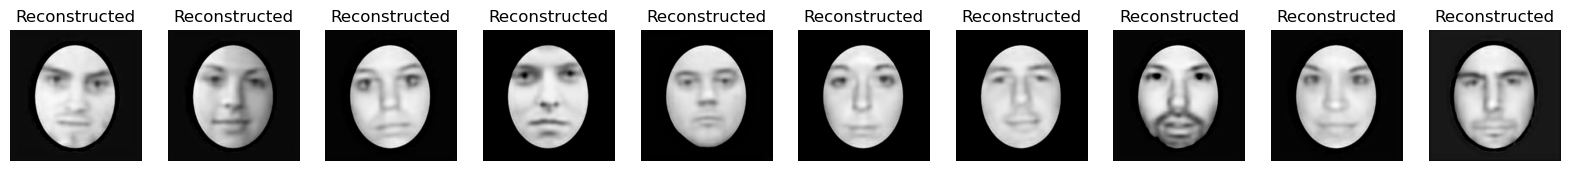

In [13]:
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):    
    # Display reconstruction
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(pred[i].reshape(300, 300), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()

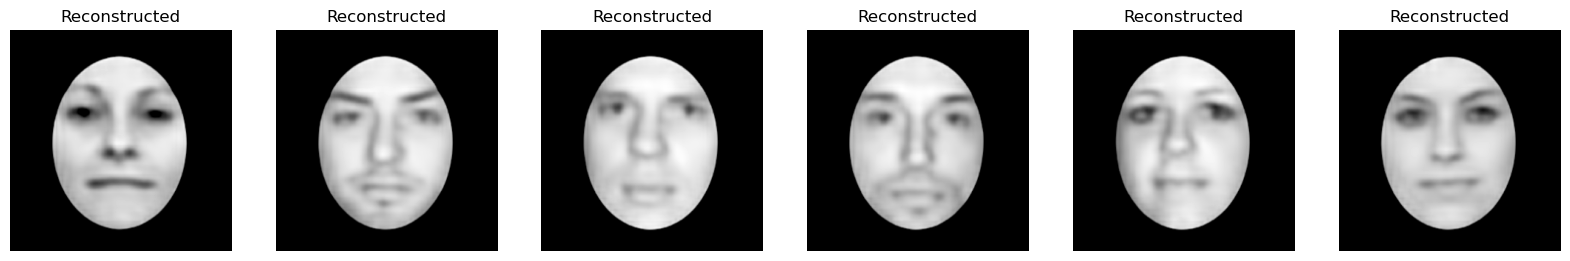

In [20]:
n = 6  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):    
    # Display reconstruction
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(pred[i].reshape(300, 300), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()

In [ ]:
for latent in [32, 64, 128]:
    model = create_resnet_autoencoder(input_latent=latent)
    chekpoint_path = f'Modeles/STIM/Autoencoder_white_{latent}.hdf5'
    checkpoint_callback = ModelCheckpoint(
        filepath=chekpoint_path,
        save_weights_only=False,
        save_frequency='epoch',
        save_best_only=True)    
    model.fit(x=trainset_white, epochs=15000, validation_data=trainset_white, verbose=0)

for latent in [32, 64, 128]:
    model = create_resnet_autoencoder(input_latent=latent)
    chekpoint_path = f'Modeles/STIM/Autoencoder_asian_{latent}.hdf5'
    checkpoint_callback = ModelCheckpoint(
        filepath=chekpoint_path,
        save_weights_only=False,
        save_frequency='epoch',
        save_best_only=True)    
    model.fit(x=trainset_asian, epochs=15000, validation_data=trainset_asian, verbose=0)

In [ ]:
# Function to generate unique random vectors
def generate_unique_vectors(num_vectors, vector_length, vectors):
    vectors_liste = []
    while len(vectors_liste) < num_vectors:
        vector = tuple(np.random.randint(0, 2, vector_length))
        if vector not in vectors:
            vectors.add(vector)
            vectors_liste.append(vector)
    return vectors_liste, vectors

# Function to convert generator to numpy arrays
def generator_to_array(generator, class_vectors):
    samples = []
    vectors = []
    data_filenames = generator.filenames
    total_images = len(data_filenames)

    for i in range(len(generator)):
        batch = generator.next()
        batch_size = len(batch[0])

        for j in range(batch_size):
            index = i * generator.batch_size + j
            if index >= total_images:
                break  # Prevent going out of bounds

            samples.append(batch[0][j])
            class_name = data_filenames[index].split(os.path.sep)[0]
            vectors.append(class_vectors[class_name])
            
    return np.array(samples), np.array(vectors), data_filenames

def preprocess(train_generator, val_generator, n, total_vectors):
    class_indices = train_generator.class_indices
    unique_vectors, total_vectors = generate_unique_vectors(n, 56, total_vectors)
    class_vectors =  {class_name: vector for class_name, vector in zip(class_indices, unique_vectors)}
    samples_train, vectors_train, _ = generator_to_array(train_generator, class_vectors)
    samples_val, vectors_val, _ = generator_to_array(val_generator, class_vectors)
    return samples_train, vectors_train, samples_val, vectors_val, total_vectors

# Data generator with rescaling and validation split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.02, dtype='float16')

def load_data(datagen, target_size = (150, 150), batch_size = 64, class_mode = 'input', shuffle = False, color_mode = 'grayscale'):
    ethnies = {'caucasians': [], 'afro_americans': [], 'asians': []}
    total_vectors = set()
    check = True
    for ethnie in ethnies.keys():
        trainset = datagen.flow_from_directory(f'../../Datasets/VGG/{ethnie}', target_size = target_size, batch_size = batch_size, class_mode = class_mode, shuffle = shuffle, color_mode = color_mode)
        testset = datagen.flow_from_directory(f'../../Datasets/VGG/{ethnie}', target_size = target_size, batch_size = batch_size, class_mode = class_mode, shuffle = shuffle, color_mode = color_mode, subset = 'validation')
        samples_train, vectors_train, samples_val, vectors_val, total_vectors = preprocess(trainset, testset, 56, total_vectors)
        if trainset.n != samples_train.shape[0] or testset.n != samples_val.shape[0]:
            check = False
        ethnies[ethnie] = [trainset, testset, samples_train, vectors_train, samples_val, vectors_val]
    print(check)
    return ethnies

ethnies = load_data(datagen)

In [ ]:
model = create_resnet_autoencoder_fairface(input_latent=256)

In [ ]:
x_train = ethnies['caucasians'][0]
x_val   = ethnies['caucasians'][1]

In [ ]:
model.fit(x=x_train, epochs = 20, validation_data=x_val, verbose=2)

In [ ]:
images = ethnies['caucasians'][2]

In [ ]:
np.random.shuffle(images)

In [ ]:
test = images[0:5]

In [ ]:
prediction = model.predict(test)

num_images = 5
plt.figure(figsize=(10, 4))
for i in range(num_images):
    # Afficher l'image originale
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(cv2.resize(test[i],(150, 150), interpolation=cv2.INTER_LINEAR), cmap='gray')
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(cv2.resize(prediction[i], (150, 150), interpolation=cv2.INTER_LINEAR), cmap='gray')
    plt.title("Reconstruction")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Pour la MSE DNN : 
# 1 °) On crée un modèle qui sache discriminer entre les carctéristiques propres aux deux ethnies
# (donc, par exemple, un AE ayant été entraîné sur datatrain_mixed qui comporte les deux ethnies à part égale lors de l'entraînement)
AE_non_biased = create_resnet_autoencoder()
chekpoint_path = f'Modeles/STIM/Autoencoder_mixte_64.hdf5'
checkpoint_callback = ModelCheckpoint(
    filepath=chekpoint_path,
    save_weights_only=False,
    save_frequency='epoch',
    save_best_only=True)
AE_non_biased.fit(x=trainset_mixed, epochs = 10000, validation_data=trainset_mixed, callbacks=[checkpoint_callback])

In [ ]:
test_asian = generator_to_array(testset_asian).reshape(6, 150, 150)
test_asian_predict = AE_non_biased.predict(testset_asian).reshape(6, 150, 150)
test_white = generator_to_array(testset_white).reshape(6, 150, 150)
test_white_predict = AE_non_biased.predict(testset_white).reshape(6, 150, 150)

In [ ]:
comparaison_visages(test_asian, test_asian_predict, test_white, test_white_predict, "mixte")

In [ ]:
for i in range(6):
    print(ssim(test_asian[i], test_asian_predict[i], data_range=test_asian.max() - test_asian.min(), multichannel=False))

In [ ]:
for i in range(6):
    print(mse(test_asian[i], test_asian_predict[i]).numpy())

In [ ]:
comparaison_visages(test_asian, test_asian_predict, test_white, test_white_predict, "asian")

In [ ]:
for  ethnie in ["white", "asian"]:
    for latent in [32]:
        model = load_model(f'Modeles/STIM/Autoencoder_{ethnie}_{latent}.hdf5', custom_objects={'loss_ssim': loss_ssim})
        get_latent = keras.Model(inputs=model.input, outputs=model.get_layer('latent_space_layer_norm').output)

        latent_asian = get_latent.predict(trainset_asian)
        latent_white = get_latent.predict(trainset_white)

        asian_predict = model.predict(trainset_asian).reshape(50,150,150)
        white_predict = model.predict(trainset_white).reshape(50,150,150)
        asian = generator_to_array(trainset_asian).reshape(50,150,150)
        white = generator_to_array(trainset_white).reshape(50,150,150)

        asian_predict_flatten = asian_predict.reshape(50, -1)
        white_predict_flatten = white_predict.reshape(50, -1)
        asian_flatten = asian.reshape(50, -1)
        white_flatten = white.reshape(50, -1)

        test_asian = generator_to_array(trainset_asian)
        test_asian_predict = model.predict(test_asian)
        test_white = generator_to_array(trainset_white)
        test_white_predict = model.predict(test_white)

        comparaison_visages(test_asian, test_asian_predict, test_white, test_white_predict, ethnie)
        latent_pca = pca(latent_asian, latent_white, ethnie)
        cosinus_similarity(asian_flatten, asian_predict_flatten, white_flatten, white_predict_flatten)
        comparaison_dispersion(latent_asian, latent_white)

In [ ]:
get_features_map_1 = keras.Model(inputs=model.input, outputs=model.get_layer('conv2d_11').output)
get_features_map_3 = keras.Model(inputs=model.input, outputs=model.get_layer('conv2d_13').output)
get_features_map_2 = keras.Model(inputs=model.input, outputs=model.get_layer('conv2d_14').output)

In [ ]:
get_latent = keras.Model(inputs=model.input, outputs=model.get_layer('latent_space_layer_norm').output)

In [ ]:
model = load_model(f'Modeles/STIM/Autoencoder_white_128.hdf5', custom_objects={'loss_ssim': loss_ssim})

In [ ]:
test_asian = generator_to_array(testset_asian)
test_asian_predict = model.predict(test_asian, verbose = 0)
test_white = generator_to_array(testset_white)
test_white_predict = model.predict(test_white, verbose = 0)

In [ ]:
comparaison_visages(test_asian, test_asian_predict, test_white, test_white_predict, "white")

In [ ]:
def mean_bhatta(latent_asian, latent_white):
    res = 0
    for i in range(len(latent_asian)):
        res += bhatta_coeff(latent_asian[i], latent_white[i])
        return res/len(latent_asian)

In [ ]:
asian = generator_to_array(trainset_asian).reshape(50,-1)
white = generator_to_array(trainset_white).reshape(50,-1)

In [ ]:
white_predict.shape

In [ ]:
def mean_bhatta_coeff(p, q):
    bhatta = 0
    if p.ndim == 1:
        for i in range(p.shape[0]):
            bhatta += np.sqrt((p[i] * q[i]))
        return bhatta
    else:
        for i in range(p.shape[0]):
            for j in range(p.shape[1]):
                bhatta += np.sqrt((p[i, j] * q[i, j]))
    return bhatta/p.shape[0]

In [ ]:
for  ethnie in ["white", "asian"]:
    for latent in [32, 64, 128]:
        model = load_model(f'Modeles/STIM/Autoencoder_{ethnie}_{latent}.hdf5', custom_objects={'loss_ssim': loss_ssim})
        get_latent = keras.Model(inputs=model.input, outputs=model.get_layer('latent_space_layer_norm').output)
        latent_asian = get_latent.predict(trainset_asian, verbose=0)
        latent_white = get_latent.predict(trainset_white, verbose=0)
        print(f"bhatta_coeff pour {ethnie}_{latent} =  {mean_bhatta_coeff(tf.nn.softmax(latent_asian, axis=1).numpy(), tf.nn.softmax(latent_white, axis=1).numpy())}")

In [ ]:
bhatta = 0
for i in range(50):
    bhatta += np.sqrt(np.dot(latent_asian_distrib[0], latent_white_distrib[0]))

In [ ]:
distrib = tf.nn.softmax(latent_asian, axis=1).numpy()

In [ ]:
distrib[4].sum()

In [ ]:
distrib.shape

In [ ]:
mean_bhatta_coeff(latent_asian_distrib, latent_white_distrib)